In [1]:
from mave_calibration.initializations import gmm_init
from mave_calibration.skew_normal import density_utils,fit
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mave_calibration import em_opt
from mave_calibration.em_opt import utils
from tqdm.autonotebook import trange
import joblib
from mave_calibration.em_opt.constraints import density_constraint_violated

/tmp/ipykernel_609169/2432241395.py:9: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


In [2]:
def plot(X, S, current_weights, current_params):
    N_samples = S.shape[1]
    fig,ax = plt.subplots(N_samples,1,figsize=(10,10),sharex=True,sharey=True)
    for sample_num in range(N_samples):
        sns.histplot(X[S[:,sample_num]], ax=ax[sample_num] ,stat='density')
    layer_distributions(X, S, current_weights, current_params, ax, label='estimated')
    return fig,ax

def layer_distributions(X, S, weights_, params_, ax,label="",linestyle='-'):
    cmap = sns.color_palette("tab10", S.shape[1] + 1)
    N_samples = S.shape[1]
    rng = np.arange(X.min(), X.max(), .01)
    for sample_num in range(N_samples):
        component_joint_pdfs = density_utils.joint_densities(rng, params_, weights_[sample_num])
        for component_num in range(N_components):
            ax[sample_num].plot(rng, component_joint_pdfs[component_num],
                label=f"Component {component_num} {label}",
                color=cmap[component_num],
                linestyle=linestyle)
            mixture_pdf = component_joint_pdfs.sum(axis=0)
        ax[sample_num].plot(rng, mixture_pdf, label=f"Mixture {label}",color=cmap[-1],linestyle=linestyle)

load data

In [3]:
data = joblib.load("/mnt/d/urn_mavedb_00000013-a-1.pkl")

sample data

In [4]:
sample_names = ['pathogenic_missense','synonymous','missense']
X = np.zeros((0,))
S = np.zeros((0,len(sample_names)),dtype=bool)
for i,sample_name in enumerate(sample_names):
    X = np.concatenate((X,data[sample_name]))
    si = np.zeros((data[sample_name].shape[0],len(sample_names)),dtype=bool)
    si[:,i] = True
    S = np.concatenate((S,si))

initialize model

In [5]:
N_samples = S.shape[1]
N_components = 2
initial_params = gmm_init(X[S[:,2]],n_inits=10,n_components=N_components)

W = np.ones((N_samples, N_components)) / N_components
W = em_opt.utils.get_sample_weights(X, S, initial_params, W)
likelihoods = [em_opt.utils.get_likelihood(X, S, initial_params, W)/len(S),]
updated_component_params, updated_weights = em_opt.utils.em_iteration(X, S, initial_params, W)
likelihoods.append(em_opt.utils.get_likelihood(X, S, updated_component_params, updated_weights)/len(S))
for i in trange(1000):
    updated_component_params, updated_weights = em_opt.utils.em_iteration(X, S, updated_component_params, updated_weights)
    likelihoods.append(em_opt.utils.get_likelihood(X, S, updated_component_params, updated_weights)/len(S))
    if np.abs(likelihoods[-1] - likelihoods[-2]) < 1e-6:
        break

 25%|██▌       | 252/1000 [00:03<00:11, 67.51it/s]


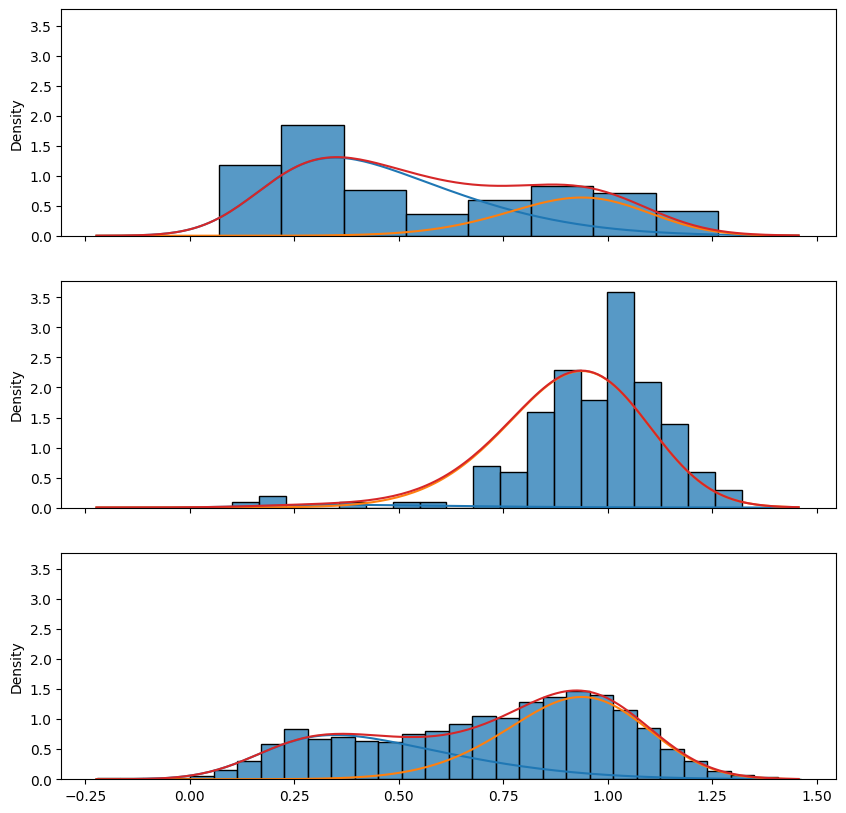

In [7]:
fig, ax = plot(X,S,updated_weights,updated_component_params)

In [12]:
(np.array(likelihoods) * -1).min()

np.float64(0.13113676856382508)

Text(0, 0.5, 'Negative Log Likelihood')

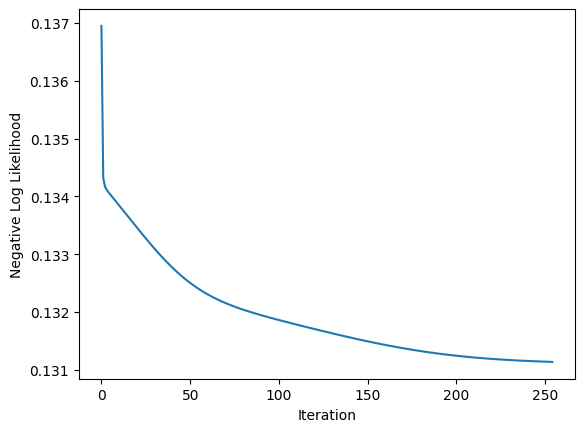

In [ ]:
plt.plot(np.array(likelihoods) * -1)
plt.xlabel('Iteration')
plt.ylabel('Negative Log Likelihood')

In [8]:
def prior_from_weights(W):
    return ((W[2,0] - W[1,0]) / (W[0,0] - W[1,0])).item()

In [9]:
prior_from_weights(updated_weights)

0.5513002165666413

In [13]:
def P2LR(p,alpha):
    p = np.clip(p,1e-6,1-1e-6)
    return np.log10(p) - np.log10(1 - p) + np.log10(1-alpha) - np.log10(alpha)

def LR2P(lr,alpha):
    LOP = lr + np.log10(alpha) - np.log10(1-alpha)
    return 10**LOP / (1 + 10**LOP)

(0.001, 0.999)

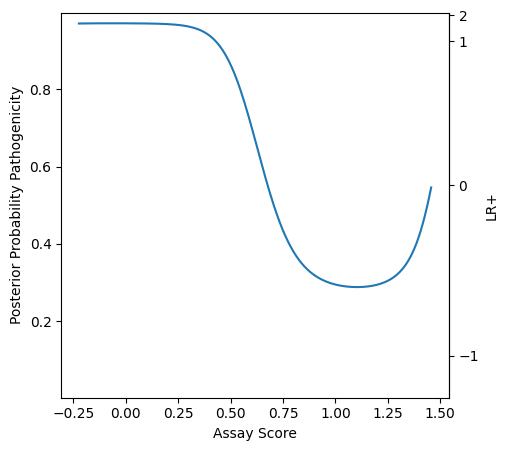

In [15]:
rng = np.arange(X.min(), X.max(), .01)
prior = prior_from_weights(updated_weights)
f_P = density_utils.joint_densities(rng, updated_component_params, updated_weights[0]).sum(0)
f_B = density_utils.joint_densities(rng, updated_component_params, updated_weights[1]).sum(0)
posterior = (prior * f_P) / (prior * f_P + (1 - prior) * f_B)



fig, ax = plt.subplots(1,1,figsize=(5,5),sharex=True)
try:
    ax[0]
except TypeError:
    ax = [ax]
secax = ax[0].secondary_yaxis('right', functions=(lambda p: P2LR(p,prior), lambda lr: LR2P(lr,prior)))
# secax.set_yscale('log')
secax.set_yticks(np.arange(-1,3),minor=False)
ax[0].plot(rng, posterior)
ax[0].set_xlabel("Assay Score")
ax[0].set_ylabel("Posterior Probability Pathogenicity")
secax.set_ylabel("LR+")
ax[0].set_ylim(1e-3,1.0 - 1e-3)


In [11]:
density_constraint_violated(*updated_component_params, (X.min(), X.max()))

True